In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import scipy.integrate as scpi

import os 

import cbmos_serial as cbmos
import force_functions as ff
import euler_forward as ef
import adams_bashforth as ab
import midpoint as md
import heun as he
import cell as cl

plt.style.use('seaborn-whitegrid')
plt.style.use('tableau-colorblind10')
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (6.75, 5),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [2]:
# Simulation parameters
s = 1.0    # rest length
tf = 10.0  # final time
rA = 1.5   # maximum interaction distance
dim = 1
seed=67

t_data = np.linspace(0, tf, tf*100+1)

force_names = ['cubic', 'pw. quad.', 'GLS']

defcolors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = {'cubic': defcolors[0], 'pw. quad.': defcolors[5], 'GLS': defcolors[6]}

# Solvers
solvers_ef = {'pw. quad.': cbmos.CBMSolver(ff.piecewise_polynomial, ef.solve_ivp, dim), 
             'cubic': cbmos.CBMSolver(ff.cubic, ef.solve_ivp, dim),
             'GLS': cbmos.CBMSolver(ff.gls, ef.solve_ivp, dim)}

In [3]:
# parameters fitted to relaxation time t=1.0h
params_cubic = {"mu": 5.70, "s": s, "rA": rA}
muR = 9.1
ratio = 0.21
params_poly = {'muA': ratio*muR, 'muR': muR, 'rA': rA, 'rR': 1.0/(1.0-np.sqrt(ratio)/3.0), 'n': 1.0, 'p': 1.0}
mu_gls=1.95
params_gls = {'mu': mu_gls, 'a':-2*np.log(0.002/mu_gls)}
params = {'cubic': params_cubic, 'pw. quad.': params_poly, 'GLS': params_gls}
filename_ending = {'cubic': '_cubic', 'pw. quad.': '_pwq', 'GLS': '_gls'}

In [4]:
def cubic_prime(r, mu, s, rA):
    return mu*(r-rA)*(3*r-2*s-rA)
    
def pwq_prime(r, muA, rA, muR, rR, s):
    return 2*(muR/rR*(1-r/rR)-muA/rA*(1-r/rA))
    
def gls_prime(r, mu, s):
    return mu/(1+r-s)

In [5]:
def make_hexagonal_mesh(l):
# 2D honeycomb mesh
#l=3
    n_x = l+(l//2)+((l-1)//2)
    n_y = l+(l-1)
    xcrds = [(2 * i + (j % 2)) * 0.5 for j in range(n_y) for i in range(n_x)]
    ycrds = [np.sqrt(3) * j * 0.5 for j in range(n_y) for i in range(n_x)]

    # make cell_list for the sheet
    sheet = [cl.Cell(i, [x,y], -24.0, proliferating=False, division_time_generator=lambda t: 24+t) for i, x, y in zip(range(n_x*n_y), xcrds, ycrds)]

    # delete cells to make it circular - skip for now
    #del sheet[24]
    #del sheet[20]
    #del sheet[19]
    #del sheet[3*l+1+3+1]
    #del sheet[2*l+1+3]
    #del sheet[2*l+1+2]
    #del sheet[l+1]
    #del sheet[0]

    # find middle index, delete cell there and replace with proliferating one
    m = n_x *(n_y//2)+ n_x//2
    coords = list(sheet[m].position)
    sheet[m] = cl.Cell(m, coords, -24.0, proliferating=True, division_time_generator=lambda t: 24+t)
    
    return sheet

In [6]:
# plot function
def plot_population(cell_list, color='blue'):
    fig=plt.figure()
    ax=fig.add_subplot(1,1,1)
    #colors = 10*plt.rcParams['axes.prop_cycle'].by_key()['color']
    n_cells = len(cell_list)
    for i in range(n_cells):
        #ax.add_patch(plt.Circle(cell_list[i].position ,0.5,color=colors[i], alpha=0.6))
        ax.add_patch(plt.Circle(cell_list[i].position ,0.5,color=color, alpha=0.4))
        plt.plot(cell_list[i].position[0], cell_list[i].position[1], '.', color=color)
    plt.show()

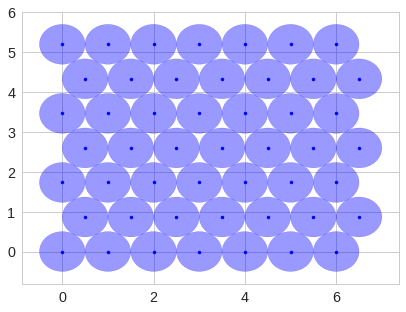

In [7]:
sheet = make_hexagonal_mesh(4)
plot_population(sheet)

# Adaptive time-stepping for two cells after proliferation

In [8]:
cell_list = [cl.Cell(0, [0], proliferating=False), cl.Cell(1, [0.3], proliferating=False)]

In [9]:
# g'(s) for different force laws
gp_cubic = params_cubic['mu']*(s-rA)**2
rR = params_poly['rR']
muA = params_poly['muA']
gp_PWQ = 2*(muR/rR*(1-s/rR)-muA/rA*(1-s/rA))
gp_GLS = params_gls['mu']

print('Analytical stability bounds:')
print('Cubic '+ str(1.0/gp_cubic))
print('PWQ '+ str(1.0/gp_PWQ))
print('GLS '+ str(1.0/gp_GLS))


Analytical stability bounds:
Cubic 0.7017543859649122
PWQ 0.6639683340575724
GLS 0.5128205128205129


[204.12625904 204.12625904]
[110.19158885 110.19158885]
[56.91761599 56.91761599]
[27.90894714 27.90894714]
[12.84827662 12.84827662]
[5.46146887 5.46146887]
[2.08238984 2.08238984]
[0.66777007 0.66777007]
[0.14233896 0.14233896]
[0.01821103 0.01821103]
[0.04148188 0.04148188]
[0.03481364 0.03481364]
[0.04770458 0.04770458]
[0.0346453 0.0346453]
[0.04768185 0.04768185]
[0.03464636 0.03464636]
[0.04768199 0.04768199]
[0.03464636 0.03464636]
[0.04768199 0.04768199]
[0.03464636 0.03464636]
[0.04768199 0.04768199]
[0.03464636 0.03464636]
Initial step cubic 0.009898412756172828
Stability bound estimate cubic 0.7037116418303313
[72.61489829 72.61489829]
[43.66684978 43.66684978]
[24.97771419 24.97771419]
[13.43229047 13.43229047]
[6.67687285 6.67687285]
[2.98624688 2.98624688]
[1.14287001 1.14287001]
[0.32839289 0.32839289]
[0.02842704 0.02842704]
[0.03781719 0.03781719]
[0.05258002 0.05258002]
[0.03902485 0.03902485]
[0.05274966 0.05274966]
[0.03901739 0.03901739]
[0.0527487 0.0527487]
[0.0

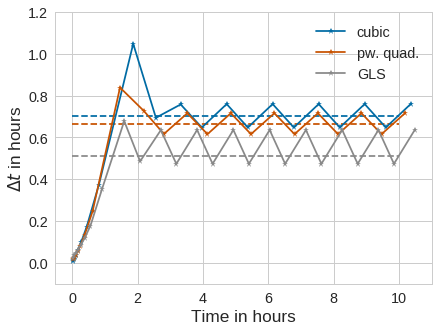

In [10]:
plt.plot(t_data, 1.0/gp_cubic*np.ones(len(t_data)), linestyle='--', color=colors['cubic'] )
plt.plot(t_data, 1.0/gp_PWQ*np.ones(len(t_data)), linestyle='--', color=colors['pw. quad.'] )
plt.plot(t_data, 1.0/gp_GLS*np.ones(len(t_data)), linestyle='--', color=colors['GLS'] )

for force in force_names:
    
    try:
        os.remove('step_sizes'+filename_ending[force]+'.txt')
        os.remove('time_points'+filename_ending[force]+'.txt')
        os.remove('AFs'+filename_ending[force]+'.txt')

    except FileNotFoundError:
        print('Nothing to delete.')
    
    history = solvers_ef[force].simulate(cell_list, t_data, params[force], {"eps": 0.01,"eta":0.0001, "out": filename_ending[force]}, seed=seed)
    dts = np.loadtxt('step_sizes'+filename_ending[force]+'.txt')
    print('Initial step '+force + ' ' +str(dts[0]))
    print('Stability bound estimate '+force + ' ' +str((dts[-2]+dts[-1])/2.0))
    ts = np.loadtxt('time_points'+filename_ending[force]+'.txt')
    plt.plot(ts, dts,'-*', label=force, color=colors[force])




plt.legend()
plt.xlabel('Time in hours')
plt.ylabel('$\Delta t$ in hours')
plt.ylim([-0.1, 1.2])
plt.savefig('adaptivity_pairwise_relaxation_eps0_01.pdf', bbox_inches='tight')
#plt.savefig('adaptivity_pairwise_relaxation_eps0_01.png', bbox_inches='tight')

[202.03486744 202.03486744]
[167.64773257 167.64773257]
[138.60180544 138.60180544]
[114.1486754 114.1486754]
[93.63311755 93.63311755]
[76.48298686 76.48298686]
[62.20004074 62.20004074]
[50.35162071 50.35162071]
[40.5631277 40.5631277]
[32.51122932 32.51122932]
[25.91774131 25.91774131]
[20.54412838 20.54412838]
[16.18657358 16.18657358]
[12.67156821 12.67156821]
[9.85197745 9.85197745]
[7.60353986 7.60353986]
[5.82176177 5.82176177]
[4.41917015 4.41917015]
[3.32289027 3.32289027]
[2.47251688 2.47251688]
[1.81824995 1.81824995]
[1.31926832 1.31926832]
[0.94231688 0.94231688]
[0.66048498 0.66048498]
[0.45215604 0.45215604]
[0.30011051 0.30011051]
[0.19076732 0.19076732]
[0.11355217 0.11355217]
[0.06038745 0.06038745]
[0.02531326 0.02531326]
[0.0043101 0.0043101]
[0.00399364 0.00399364]
[0.00412666 0.00412666]
[0.00399691 0.00399691]
[0.00412669 0.00412669]
[0.00399691 0.00399691]
[0.00412669 0.00412669]
[0.00399691 0.00399691]
[0.00412669 0.00412669]
[0.00399691 0.00399691]
[0.0041266

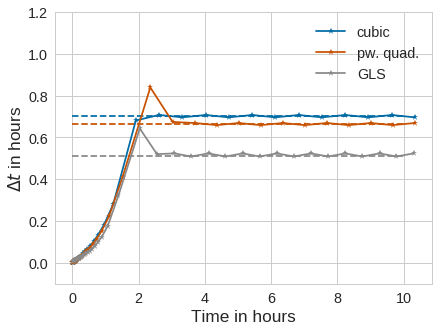

In [11]:
plt.plot(t_data, 1.0/gp_cubic*np.ones(len(t_data)), linestyle='--', color=colors['cubic'] )
plt.plot(t_data, 1.0/gp_PWQ*np.ones(len(t_data)), linestyle='--', color=colors['pw. quad.'] )
plt.plot(t_data, 1.0/gp_GLS*np.ones(len(t_data)), linestyle='--', color=colors['GLS'] )

for force in force_names:
    
    try:
        os.remove('step_sizes'+filename_ending[force]+'.txt')
        os.remove('time_points'+filename_ending[force]+'.txt')
        os.remove('AFs'+filename_ending[force]+'.txt')

    except FileNotFoundError:
        print('Nothing to delete.')
    
    history = solvers_ef[force].simulate(cell_list, t_data, params[force], {"eps": 0.001, "eta":0.001, "out": filename_ending[force]}, seed=seed)
    dts = np.loadtxt('step_sizes'+filename_ending[force]+'.txt')
    print('Initial step '+force + ' ' +str(dts[0]))
    print('Stability bound estimate '+force + ' ' +str((dts[-2]+dts[-1])/2.0))
    ts = np.loadtxt('time_points'+filename_ending[force]+'.txt')
    plt.plot(ts, dts,'-*', label=force, color=colors[force])

plt.legend()
plt.xlabel('Time in hours')
plt.ylabel('$\Delta t$ in hours')
plt.ylim([-0.1, 1.2])
plt.savefig('adaptivity_pairwise_relaxation_eps0_001.pdf', bbox_inches='tight')
#plt.savefig('adaptivity_pairwise_relaxation_eps0_001.png', bbox_inches='tight')


In [12]:
# Accuracy bound for initial step:
eps = 0.001
r0 = 0.3

gp_cubic = cubic_prime(r0, params_cubic['mu'], s, rA)
ab_cubic = np.sqrt(eps/(gp_cubic*np.abs(ff.cubic(r0, **params_cubic))))

gp_pwq = pwq_prime(r0, params_poly['muA'], rA, muR, params_poly['rR'], s)
ab_pwq = np.sqrt(eps/(gp_pwq*np.abs(ff.piecewise_polynomial(r0, **params_poly))))

gp_gls = gls_prime(r0, params_gls['mu'],s)
ab_gls = np.sqrt(eps/(gp_gls*np.abs(params_gls['mu']*np.log(1+r0-s))))

print('Analytical accuracy bounds for the first step, eps= '+ str(eps))
print('Cubic '+str(ab_cubic))
print('PWQ '+ str(ab_pwq))
print('GLS' + str(ab_gls))

Analytical accuracy bounds for the first step, eps= 0.001
Cubic 0.003128366173325387
PWQ 0.005246890209381213
GLS0.008095015365876104


# Dependence of initial step and stability bound on number of neigbors

In [13]:
dim = 2
solvers_ef = {'pw. quad.': cbmos.CBMSolver(ff.piecewise_polynomial, ef.solve_ivp, dim), 
             'cubic': cbmos.CBMSolver(ff.cubic, ef.solve_ivp, dim),
             'GLS': cbmos.CBMSolver(ff.gls, ef.solve_ivp, dim)}

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 8.26445641e-02 1.43033830e-01
 5.95447108e-02 1.11609509e-01 1.11033470e-02 1.92257611e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.10554504e-01 1.21277899e-01 1.73893262e+00 7.93260376e+00
 1.17806737e+00 6.40560704e-01 6.81123187e-02 1.65828414e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.33276134e-01 6.87804557e-05 1.65120075e+01 1.83242947e+00
 1.78058921e+02 5.23968881e+01 1.65120075e+01 1.83242947e+00
 3.33276134e-01 6.87804557e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 6.81123187e-02 1.65828414e-01 1.17806737e+00 6.40560704e-01
 1.73893262e+00 7.932603

[1.33901836e-03 7.61461347e-04 2.25256374e-03 1.01063799e-03
 1.24221607e-02 1.88146937e-02 4.50566644e-03 7.64770644e-03
 5.73223878e-03 7.59189246e-03 8.87052745e-04 1.81452653e-03
 1.56025230e-04 3.90528025e-04 3.14588797e-03 2.33004188e-03
 1.65573102e-02 6.08638230e-03 6.38848838e-02 9.81722819e-02
 4.62233926e-02 3.92223183e-02 7.31874783e-03 1.26318632e-02
 5.60582005e-03 9.93338260e-03 7.29111290e-04 1.29944758e-04
 2.09670412e-03 9.42324890e-04 1.29283657e-02 1.20492487e-02
 4.62835748e-02 2.74678598e-02 8.83299239e-02 3.67643403e-01
 3.71198523e-02 6.56809485e-02 1.12744539e-02 5.98068648e-02
 5.14373888e-03 8.90405062e-03 2.24940911e-02 1.83845914e-04
 1.19561292e-01 5.56582072e-03 3.69128456e-01 1.06513637e-01
 7.96629339e-01 4.57609156e-01 3.66515728e-01 1.05003555e-01
 1.17445557e-01 4.87991637e-03 2.11241825e-02 1.76868659e-04
 7.62629852e-04 6.84128970e-04 6.13255683e-03 9.40879220e-03
 1.19104118e-02 6.14224944e-02 3.70132012e-02 6.44457712e-02
 9.03854605e-02 3.700782

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 8.79895532e-02 1.52283315e-01
 6.34873853e-02 1.18843743e-01 1.27174815e-02 2.20203145e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.17286058e-01 1.28542253e-01 1.24910233e+00 4.53334852e+00
 6.97538064e-01 4.24290854e-01 6.96595516e-02 1.74556847e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.51747388e-01 7.09772915e-05 9.38768374e+00 8.12939431e-01
 6.61596199e+01 1.94912541e+01 9.38768374e+00 8.12939431e-01
 3.51747388e-01 7.09772915e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 6.96595516e-02 1.74556847e-01 6.97538064e-01 4.24290854e-01
 1.24910233e+00 4.533348

 4.90867311e-03 2.75370607e-03 7.05999426e-01 4.01524297e-01]
[2.49879692e-03 1.73020087e-03 3.32753044e-03 7.25152741e-04
 1.70914948e-02 2.55729758e-02 5.10837854e-03 1.00514725e-02
 9.02067957e-03 1.17069447e-02 1.54299978e-03 3.31480852e-03
 7.06855759e-04 1.50897211e-03 5.06953104e-03 4.14650350e-03
 2.27488464e-02 2.16656342e-03 7.50646019e-02 1.05407338e-01
 5.68204470e-02 4.88327297e-02 9.09649941e-03 1.65592422e-02
 9.77009012e-03 1.70971706e-02 1.66632867e-03 2.57117277e-04
 2.24972150e-03 1.24452635e-03 1.26532222e-02 1.99566622e-02
 2.52002887e-02 1.54128477e-02 7.40185272e-02 3.23126398e-01
 3.35230985e-02 5.98615592e-02 1.53055909e-02 7.57691335e-02
 7.62480199e-03 1.13861593e-02 3.14332675e-02 8.26959030e-04
 1.33740736e-01 1.08292900e-02 3.25731606e-01 9.83344335e-02
 6.57506985e-01 3.77039853e-01 3.21099266e-01 9.62572998e-02
 1.30032792e-01 1.01587612e-02 2.85788764e-02 4.89255572e-04
 1.45553867e-03 1.26339192e-03 9.66087656e-03 1.23195028e-02
 1.64726538e-02 7.79034

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.60178651e-01 2.77253748e-01
 9.27982831e-02 2.00352492e-01 5.44210534e-05 9.42302244e-05
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.24367215e-01 1.96605446e-01 7.08862679e-01 1.64113901e+00
 1.25240314e-01 8.86249824e-02 1.17600270e-01 2.44823727e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 5.10586798e-01 8.37898212e-05 2.74410810e+00 1.59596269e-01
 2.49399420e+01 7.27374870e+00 2.74410810e+00 1.59596269e-01
 5.10586798e-01 8.37898212e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.17600270e-01 2.44823727e-01 1.25240314e-01 8.86249824e-02
 7.08862679e-01 1.641139

 3.12573748e-02 4.61065298e-02 3.80748988e-01 1.75165118e-01]
[0.13256019 0.10865886 0.2307982  0.03648484 0.14274774 0.10117528
 0.01728229 0.03376164 0.04068419 0.02992621 0.01939988 0.04382871
 0.01188358 0.03487944 0.21289347 0.38780619 0.34771125 0.16259191
 0.24149516 0.25063802 0.11115642 0.11967932 0.03104704 0.09872789
 0.04412168 0.09852351 0.02461601 0.00060246 0.13416754 0.05881847
 0.27674928 0.30625145 0.1707124  0.15198451 0.08760417 0.32530438
 0.01122564 0.0847172  0.03218661 0.12592139 0.01418925 0.01245574
 0.09503392 0.00357247 0.30172044 0.08937059 0.37022691 0.03296922
 0.35584419 0.15081011 0.26848938 0.05183135 0.16274378 0.01599898
 0.0513409  0.00120371 0.05297447 0.00958011 0.09832778 0.06851064
 0.06837457 0.17040216 0.0079745  0.08020365 0.04057343 0.24699459
 0.05432991 0.04977204 0.02564754 0.05850653 0.06798516 0.12480391
 0.10087928 0.16497387 0.00622953 0.09043586 0.06965933 0.09349771
 0.14151806 0.17291272 0.15661776 0.06200032 0.06979251 0.0116888
 

Text(0, 0.5, '$\\Delta t$ in hours')

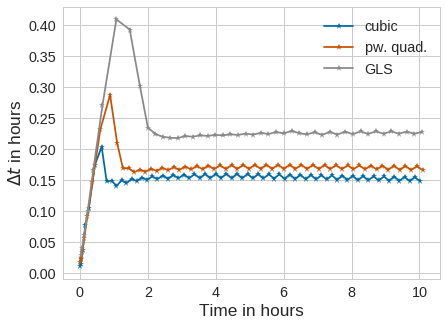

In [44]:
sheet = make_hexagonal_mesh(4)

for force in force_names:
    
    try:
        os.remove('step_sizes'+filename_ending[force]+'.txt')
        os.remove('time_points'+filename_ending[force]+'.txt')
        os.remove('AFs'+filename_ending[force]+'.txt')

    except FileNotFoundError:
        print('Nothing to delete.')
    
    history = solvers_ef[force].simulate(sheet, t_data, params[force], {"eps": 0.01, "out": filename_ending[force]}, seed=seed)
    dts = np.loadtxt('step_sizes'+filename_ending[force]+'.txt')
    print('Initial step '+force + ' ' +str(dts[0]))
    print('Stability bound estimate '+force + ' ' +str((dts[-2]+dts[-1])/2.0))
    ts = np.loadtxt('time_points'+filename_ending[force]+'.txt')
    plt.plot(ts, dts,'-*', label=force, color=colors[force])
plt.legend()
plt.xlabel('Time in hours')
plt.ylabel('$\Delta t$ in hours')
#plt.savefig('adaptivity_38cells.pdf', bbox_inches='tight')
#plt.savefig('adaptivity_38cells.png', bbox_inches='tight')

In [45]:
AFs = np.loadtxt('AFs'+filename_ending['cubic']+'.txt')
sorted_AFs = np.sort(AFs)


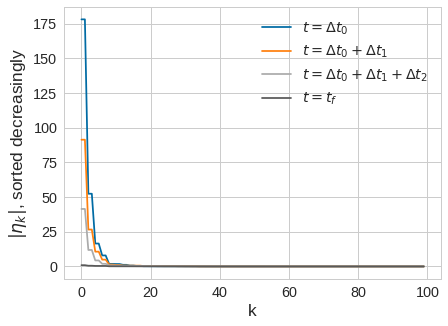

In [46]:
plt.plot(sorted_AFs[0,::-1], label='$t=\Delta t_0$')
plt.plot(sorted_AFs[1,::-1], label='$t=\Delta t_0+\Delta t_1$')
plt.plot(sorted_AFs[2,::-1], label='$t=\Delta t_0+\Delta t_1+\Delta t_2$')

plt.plot(sorted_AFs[-1,::-1], label='$t=t_f$')
plt.xlabel('k')
plt.ylabel('$|\eta_k|$, sorted decreasingly')
plt.legend()

In [43]:
sorted_AFs[0,::-1]

array([1.78058921e+02, 1.78058921e+02, 5.23968881e+01, 5.23968881e+01,
       1.65120075e+01, 1.65120075e+01, 7.93260376e+00, 7.93260376e+00,
       1.83242947e+00, 1.83242947e+00, 1.73893262e+00, 1.73893262e+00,
       1.17806737e+00, 1.17806737e+00, 6.40560704e-01, 6.40560704e-01,
       3.33276134e-01, 3.33276134e-01, 1.65828414e-01, 1.65828414e-01,
       1.43033830e-01, 1.43033830e-01, 1.21277899e-01, 1.21277899e-01,
       1.11609509e-01, 1.11609509e-01, 1.10554504e-01, 1.10554504e-01,
       8.26445641e-02, 8.26445641e-02, 6.81123187e-02, 6.81123187e-02,
       5.95447108e-02, 5.95447108e-02, 1.92257611e-02, 1.92257611e-02,
       1.11033470e-02, 1.11033470e-02, 6.87804557e-05, 6.87804557e-05,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [15]:
initial_step = {'cubic':[], 'pw. quad.': [], 'GLS': []}
stability_bounds = {'cubic':[], 'pw. quad.': [], 'GLS': []}
sl = [2, 3, 4, 5, 8, 10, 15]
for l in sl:
    sheet = make_hexagonal_mesh(l)
    
    for force in force_names:
    
        try:
            os.remove('step_sizes'+filename_ending[force]+'.txt')
            os.remove('time_points'+filename_ending[force]+'.txt')
        except FileNotFoundError:
            print('Nothing to delete.')
    
        history = solvers_ef[force].simulate(sheet, t_data, params[force], {"eps": 0.01, "out": filename_ending[force]}, seed=seed)
        dts = np.loadtxt('step_sizes'+filename_ending[force]+'.txt')
        sbe = (dts[-2]+dts[-1])/2.0
        #print('Initial step '+force + ' ' +str(dts[0]))
        #print('Stability bound estimate '+force + ' ' +str(sbe))
        initial_step[force].append(dts[0])
        stability_bounds[force].append(sbe)
        


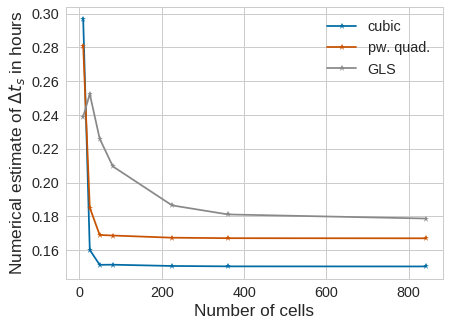

In [16]:
n_cells = [(2*l-1)*(l+(l-1)//2+l//2) for l in sl]
for force in force_names:
    plt.plot(n_cells, stability_bounds[force], '-*', label=force, color=colors[force])

plt.legend()
plt.xlabel('Number of cells')
plt.ylabel('Numerical estimate of $\Delta t_s$ in hours')
plt.savefig('dependence_stability_n_cells.pdf', bbox_inches='tight')

Text(0, 0.5, 'Numerical estimate of $\\Delta t_0$ in hours')

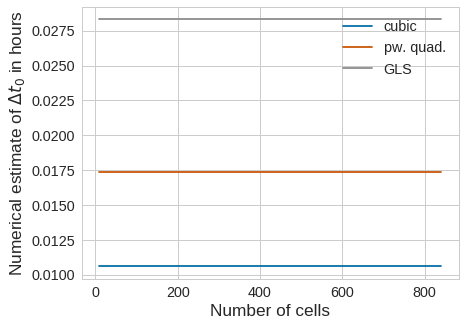

In [17]:
for force in force_names:
    plt.plot(n_cells, initial_step[force], label=force, color=colors[force])

plt.legend()
plt.xlabel('Number of cells')
plt.ylabel('Numerical estimate of $\Delta t_0$ in hours')

# Dependence of the initial step on epsilon

In [18]:
initial_step = {'cubic':[], 'pw. quad.': [], 'GLS': []}
sheet = make_hexagonal_mesh(4)

tolerances= [0.01, 0.001, 0.0001]
for eps in tolerances:
    
    for force in force_names:
    
        try:
            os.remove('step_sizes'+filename_ending[force]+'.txt')
            os.remove('time_points'+filename_ending[force]+'.txt')
        except FileNotFoundError:
            print('Nothing to delete.')
    
        history = solvers_ef[force].simulate(sheet, t_data, params[force], {"eps": eps, "out": filename_ending[force]}, seed=seed)
        dts = np.loadtxt('step_sizes'+filename_ending[force]+'.txt')
        #print('Initial step '+force + ' ' +str(dts[0]))
        #print('Stability bound estimate '+force + ' ' +str(sbe))
        initial_step[force].append(dts[0])

        

Text(0, 0.5, 'Numerical estimate of $\\Delta t_0$ in hours')

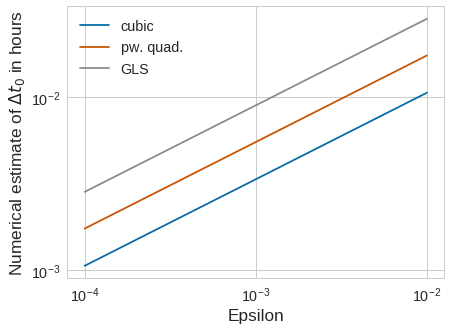

In [19]:
for force in force_names:
    plt.loglog(tolerances, initial_step[force], label=force, color=colors[force])

plt.legend()
plt.xlabel('Epsilon')
plt.ylabel('Numerical estimate of $\Delta t_0$ in hours')